In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, classification_report, confusion_matrix, 
                             roc_curve, auc, f1_score, matthews_corrcoef)
from imblearn.over_sampling import SMOTE
import shap
import joblib
import xgboost as xgb

In [2]:
# Load dataset
df = pd.read_csv('filtered_data.csv')
print("Initial dataset shape:", df.shape)

Initial dataset shape: (15000, 19)


In [3]:
# Step 1: Data Exploration and Initial Checks
print("Initial missing values:\n", df.isnull().sum())
df.info()

Initial missing values:
 iyear             0
imonth            0
country           0
region            0
provstate         0
city              4
attacktype1       0
targtype1         0
corp1           290
target1           3
natlty1         210
weaptype1         0
nkill           803
nwound         1330
property          0
propextent     9571
propvalue      9926
gname             0
success           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iyear        15000 non-null  int64  
 1   imonth       15000 non-null  int64  
 2   country      15000 non-null  int64  
 3   region       15000 non-null  int64  
 4   provstate    15000 non-null  object 
 5   city         14996 non-null  object 
 6   attacktype1  15000 non-null  int64  
 7   targtype1    15000 non-null  int64  
 8   corp1        14710 non-null  object 
 9   target

In [4]:
# Step 2: Drop duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Shape after removing duplicates: (14791, 19)


In [5]:
# Step 3: Handle invalid values (replace negative values with 0)
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].mask(df[numeric_columns] < 0, 0)
print(f"Shape after replacing invalid values: {df.shape}")

Shape after replacing invalid values: (14791, 19)


In [6]:
# Step 4: Advanced Missing Value Imputation

# Use KNN imputer for numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
knn_imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

# Use most frequent imputation for categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print(f"Shape after imputation: {df.shape}")
print("Missing values after imputation:", df.isnull().sum())

Shape after imputation: (14791, 19)
Missing values after imputation: iyear          0
imonth         0
country        0
region         0
provstate      0
city           0
attacktype1    0
targtype1      0
corp1          0
target1        0
natlty1        0
weaptype1      0
nkill          0
nwound         0
property       0
propextent     0
propvalue      0
gname          0
success        0
dtype: int64


In [7]:
# Most frequent imputation for categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [9]:
# Step 5: Outlier Detection using Isolation Forest (more robust)
outlier_detector = IsolationForest(contamination=0.05)  # Adjust contamination if needed
outliers = outlier_detector.fit_predict(df[numeric_cols])
df = df[outliers == 1]  # Keep only the inliers (predicted normal rows)

print(f"Shape after outlier removal: {df.shape}")

Shape after outlier removal: (13348, 19)


In [10]:
#2. Feature Engineering
#Creating Meaningful Features to Enhance Predictive Power
# Step 1: Feature Engineering - Create more meaningful features
#  Create an interaction feature between columns 'nkill' and 'nwound'
df['total_casualties'] = df['nkill'].fillna(0) + df['nwound'].fillna(0)
# Create aggregated features based on region and attack type
df['region_attack_count'] = df.groupby('region')['attacktype1'].transform('count')

In [11]:
# Step 2: Encoding categorical variables
# Step 1: Identify all categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Step 2: Apply frequency encoding for each categorical column
for col in cat_cols:
    freq_map = df[col].value_counts() / len(df)  # Frequency distribution of categories
    df[col] = df[col].map(freq_map)  # Map frequency to each category

# Step 3: Verify the result
print(df.head())

    iyear  imonth  country  region  provstate      city  attacktype1  \
1  2020.0     1.0      4.0     6.0   0.011088  0.000075          3.0   
2  2014.0     3.0      4.0     6.0   0.004120  0.000375          3.0   
3  2018.0     4.0     95.0    10.0   0.029143  0.000075          3.0   
5  2014.0     7.0     37.0    11.0   0.002772  0.000075          2.0   
6  2016.0     9.0     95.0    10.0   0.032514  0.000450          3.0   

   targtype1     corp1   target1  ...  weaptype1  nkill  nwound  property  \
1       17.0  0.000075  0.005394  ...        6.0   13.0     3.0       0.0   
2        3.0  0.026221  0.032439  ...        6.0    5.0     1.0       1.0   
3        3.0  0.026071  0.034837  ...        6.0    0.0     1.0       1.0   
5        3.0  0.000524  0.005769  ...        5.0    0.0     0.0       1.0   
6       14.0  0.166916  0.007642  ...        6.0    0.0     0.0       1.0   

   propextent  propvalue     gname  success  total_casualties  \
1         3.2        0.0  0.075966     

In [12]:
# Step 8: Feature Scaling
scaler = StandardScaler()  # StandardScaler for PCA
scaled_features = scaler.fit_transform(df.select_dtypes(include=[np.number]))  # Only scale numeric columns

In [13]:
# Save scaler
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [14]:
# Step 9: Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
reduced_data = pca.fit_transform(scaled_features)
print("Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_)[-1])

Explained variance ratio: 0.9550555204968402


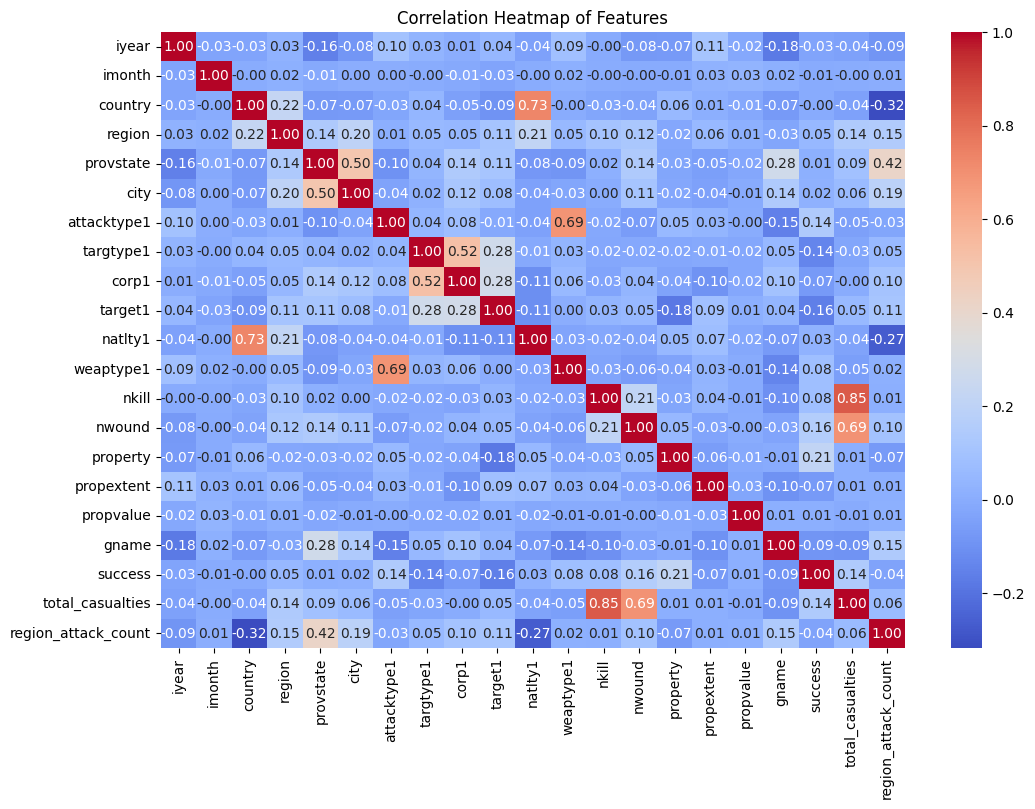

In [15]:
# Correlation Heatmap
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix for numeric columns only
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Features")
plt.show()

In [16]:
# Step 11: Save Processed Data
output_file_path = 'processed_cleaned_data.csv'
df.to_csv(output_file_path, index=False)
print(f"Processed data saved to {output_file_path}")

Processed data saved to processed_cleaned_data.csv


In [17]:
#3. Model Training
#Comparing Machine Learning Models for Best Performance
# Step 1: Modeling Preparation
features = ['region', 'attacktype1', 'weaptype1', 'nkill', 'nwound', 'total_casualties']
X = df[features]
y = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 2: Handle Imbalanced Data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log = log_reg.predict(X_test)
y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Train XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Save Models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(xgb_model, "xgboost_model.pkl")



['xgboost_model.pkl']

In [18]:
#4. Results and Analysis
#Interpreting Model Outputs and Insights
# Evaluation Function
def evaluate_model(y_test, y_pred, y_pred_proba):
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=1),
        "Recall": recall_score(y_test, y_pred, zero_division=1),
        "AUC-ROC": roc_auc_score(y_test, y_pred_proba),
    }
    return metrics

# Model Evaluations
print("Logistic Regression Metrics:", evaluate_model(y_test, y_pred_log, y_pred_proba_log))
print("Random Forest Metrics:", evaluate_model(y_test, y_pred_rf, y_pred_proba_rf))
print("XGBoost Metrics:", evaluate_model(y_test, y_pred_xgb, y_pred_proba_xgb))


Logistic Regression Metrics: {'Accuracy': 0.6556803995006242, 'Precision': np.float64(0.9741878059635068), 'Recall': np.float64(0.6236467236467237), 'AUC-ROC': np.float64(0.8031822498489165)}
Random Forest Metrics: {'Accuracy': 0.8282147315855181, 'Precision': np.float64(0.9709612817089452), 'Recall': np.float64(0.8287749287749288), 'AUC-ROC': np.float64(0.8954706610262166)}
XGBoost Metrics: {'Accuracy': 0.8267166042446942, 'Precision': np.float64(0.9709030100334448), 'Recall': np.float64(0.827065527065527), 'AUC-ROC': np.float64(0.8972166105499438)}


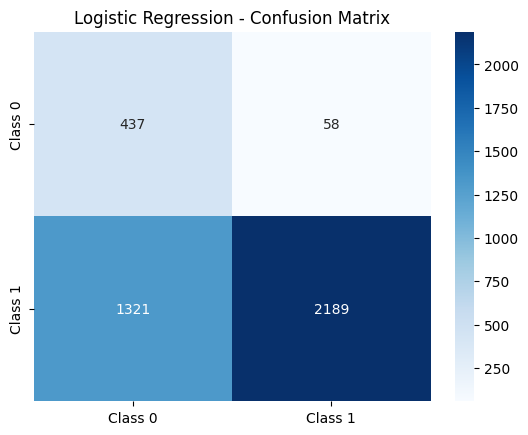

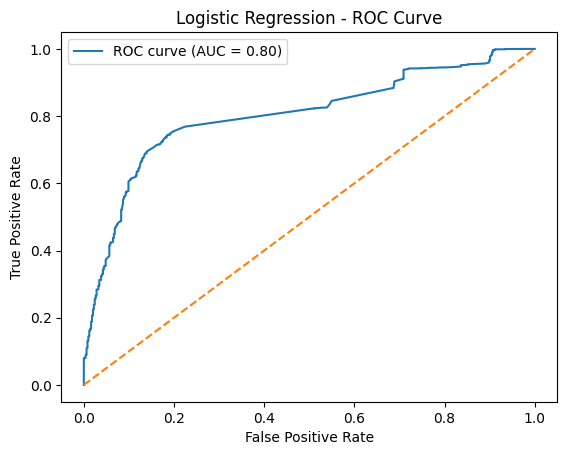

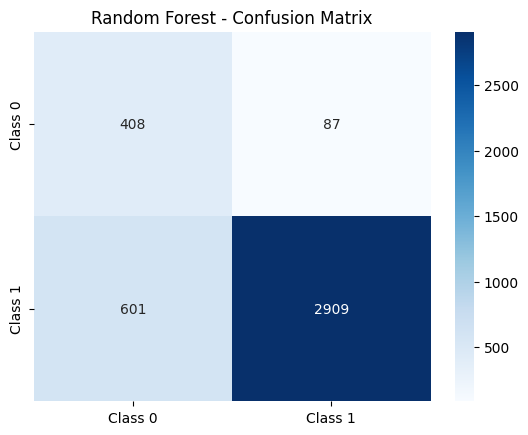

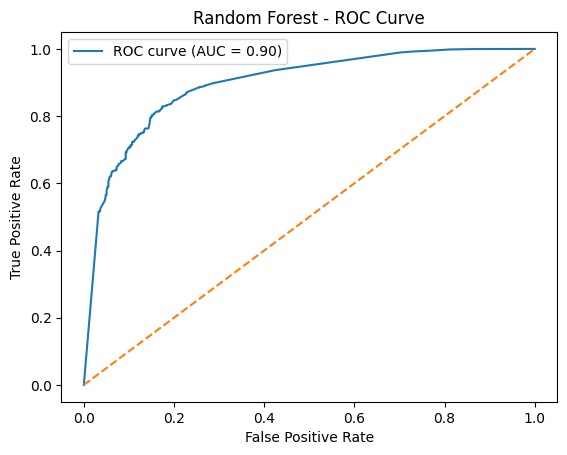

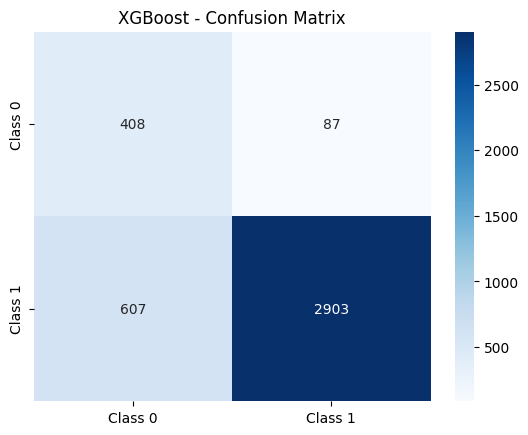

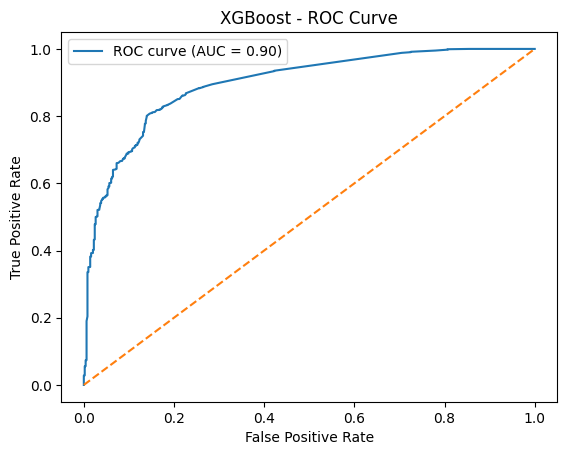

In [19]:
# Confusion Matrix & ROC Curve
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression")
plot_roc_curve(y_test, y_pred_proba_log, "Logistic Regression")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_roc_curve(y_test, y_pred_proba_rf, "Random Forest")

plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
plot_roc_curve(y_test, y_pred_proba_xgb, "XGBoost")


 96%|=================== | 3836/4005 [00:12<00:00]       

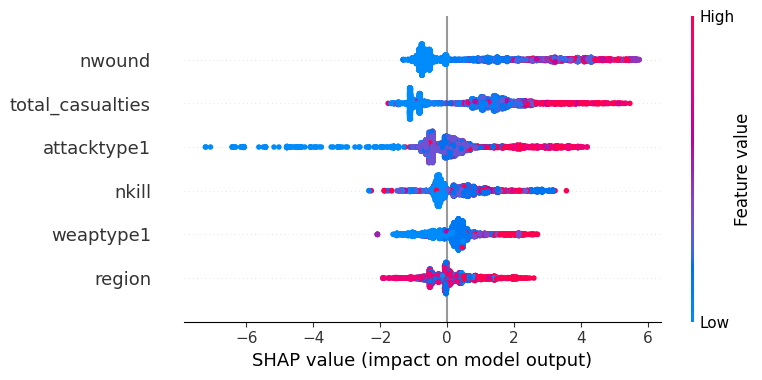

In [20]:
# SHAP Analysis for XGBoost
explainer = shap.Explainer(xgb_model, X_train_resampled)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


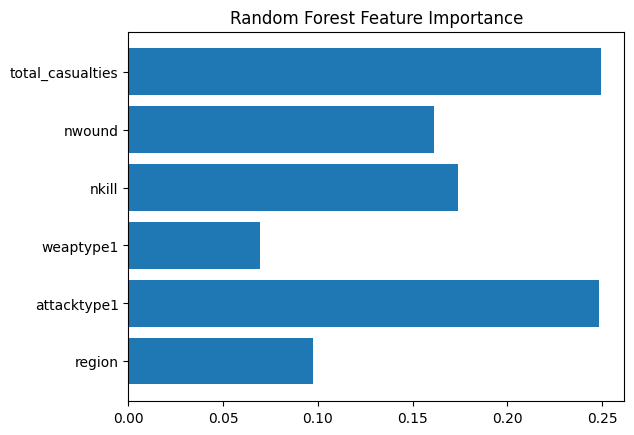

In [22]:
# Feature Importance - Random Forest
feature_importances_rf = rf.feature_importances_
plt.barh(features, feature_importances_rf)
plt.title("Random Forest Feature Importance")
plt.show()